In [2]:
push!(LOAD_PATH, "modules")

3-element Array{ByteString,1}:
 "/Applications/Julia-0.4.0.app/Contents/Resources/julia/local/share/julia/site/v0.4"
 "/Applications/Julia-0.4.0.app/Contents/Resources/julia/share/julia/site/v0.4"      
 "modules"                                                                           

In [ ]:
using IntervalArithmetic
using AutoDiff
using PurityIntervals

# The vector x = [ω, θ] in Birkhoff mapping

function alpha(n, m)
	if n > 0 && n <= 3 && m > 0 && m <= 3 && typeof(n) == Int && typeof(m) == Int && n != m
		k = pi/3
		if n == 1 && m == 2
			return 0
		elseif n == 1 && m == 3
	 		return k
		elseif n == 2 && m == 3
	 		return 2k
		elseif n == 2 && m == 1
	 		return 3k
		elseif n == 3 && m == 1
	 		return 4k
		elseif n == 3 && m == 2
	 		return 5k
	 	end
	else
	    error("Invalid parameters: should be 1, 2, 3 and not equal")
	end
end

#=
function T(x, n, m, r)
	wnext = ω - r*(ω*cos(θ - alpha(n, m)) + sqrt_d(1 - ω^2)*sin(θ - alpha(n, m)))
	[wnext, mod(θ + float(pi) + arcsin_d(x[1]) + arcsin_d(wnext), 2pi)]
end
=#

function T(x, n, m, r)
	ω, θ = x

	ω_next = ω - r*(ω*cos(θ - alpha(n, m)) + √(1 - ω^2)*sin(θ - alpha(n, m)))
	#θ_next = mod(θ + big(pi) + asin(ω) + asin(ω_next), 2π)
	θ_next = θ + big(pi) + asin(ω) + asin(ω_next)

	[ω_next, θ_next]
end


using PyPlot

distance_between_centers = 6.

#= These functions have been replaced by path()
f12(x) = T(x, 1, 2, distance_between_centers)
f13(x) = T(x, 1, 3, distance_between_centers)

function twice_123(x0)
	x1 = T(x0, 1, 2, distance_between_centers)
	x2 = T(x1, 2, 3, distance_between_centers)

	x2

end

function twice_123(x0)
	x1 = T(x0, 1, 2, distance_between_centers)
	x2 = T(x1, 2, 3, distance_between_centers)

	x2

end

function iterate_1231(x0)
	x1 = T(x0, 1, 2, distance_between_centers)
	x2 = T(x1, 2, 3, distance_between_centers)
	x3 = T(x2, 3, 1, distance_between_centers)
	x3
end
=#

# x = [ω, θ] and n is array of path points, e.g. [1, 2, 3, 1, 3]
function path(x, n)
    for i = 1:length(n)-1
        if n[i] != n[i+1]
            x = T(x, n[i], n[i+1], distance_between_centers)
        else
            error("Cannot hit the same disk twice in succession")
        end
    end
    x
end


function plot_band(f, N)

	# Split the phase space w = [-1, 1], th = [0, pi/3] into 30x30 rectangles
	rw = Interval(-0.95, 0.95)
	rth = Interval(0.05, float(pi)/3-0.05)
	deltaw = diam(rw/N)
	deltath = diam(rth/N)

	points = Array{BigFloat, 1}[]
	purities = Int[]

	for i = 1:N
		for j = 1:N
			rect = [rw.lo + i*deltaw - Interval(0, deltaw), rth.lo + j*deltath - Interval(0, deltath)]
			p = purity(f, rect)
			#println([rect, p])
			push!(points, mid(rect))
			push!(purities, p)

		end
	end

	x = [Float64(xx[1]) for xx in points]
	y = [Float64(xx[2]) for xx in points]

	p = purities

	for i in (0, 1, -1)
		plot(y[p.==i], x[p.==i], "o", label="$i", alpha = 0.5)
	end
	legend()

end

#plot_band(f12)
#plot_band(f13)

#plot_band(twice_123, 100)
#plot_band(x -> path(x, [1, 2, 3]), 100)

rect = [Interval(-0.999, 0.999), Interval(0.001, big(pi)/3-0.001)]
points = Array{Interval, 1}[]
purities = Int[]

function plot_band_bisection(f, rect, tol)
    limitrect(rect) = max(diam(rect)[1], diam(rect)[2]) < tol
    p = purity(f, rect)
    if p != -1
        if p == 1
            #println("Went to p=1")
            push!(points, rect)
            push!(purities, p)
            #println("Clean recorded")
        elseif p == 0
            #println("Went to p=0")
            if limitrect(rect)
                push!(points, rect)
                push!(purities, p)
                #println("Unclean recorded")
            else
                pieces = bisect(rect)
                for i = 1:4
                    plot_band_bisection(f, pieces[i], tol)
                end
            end
        end
    end
    points, purities
end

function plot_band_bisection_dirty(f, rect, tol)
    limitrect(rect) = max(diam(rect)[1], diam(rect)[2]) < tol
    p = purity(f, rect)
    if p == 1 || p == -1
        push!(points, rect)
        push!(purities, p)
    elseif p == 0
        if limitrect(rect)
            push!(points, rect)
            push!(purities, p)
        else
            pieces = bisect(rect)
            for i = 1:4
                plot_band_bisection_dirty(f, pieces[i], tol)
            end
        end
    end
    points, purities
end

In [70]:
# Using midpoints of rectangles! It works
#=
pts = mid(plot_band_bisection(x -> path(x, [1, 2]), rect, 1e-3))
x = [Float64(xx[1]) for xx in pts]
y = [Float64(xx[2]) for xx in pts]
plot(y, x, "o")
=#

# Function to draw rectangles
using PyCall
@pyimport matplotlib.patches as patches
rectangle = patches.Rectangle
function draw_rectangle(x, y, xwidth, ywidth, color="grey")
    ax = gca()
    ax[:add_patch](rectangle((x, y), xwidth, ywidth, facecolor=color, linewidth=0.1, alpha=0.5))
end


#=
plot_band_bisection(x -> path(x, [1, 2]), rect, 1e-3)
println(points)
println(purities)
=#

#result = plot_band_bisection(x -> path(x, [1, 2]), rect, 1e-2)

# Printing output for WM
#=
for i = 1:length(result[1])
    println("$(result[1][i][1].lo) $(result[1][i][1].hi) $(result[1][i][2].lo) $(result[1][i][2].hi) $(result[2][i])")
end
=#

#= 
points, purities = plot_band_bisection(x -> path(x, [1, 2]), rect, 1e-2)

for i = 1:length(points)
    if purities[i] == 0
        draw_rectangle(points[i][2].lo, points[i][1].lo, diam(points[i][2]), diam(points[i][1]), "green")
    elseif purities[i] == 1
        draw_rectangle(points[i][2].lo, points[i][1].lo, diam(points[i][2]), diam(points[i][1]), "blue")
    end
end
axis([0, pi/3, -1, 1])
=#

draw_rectangle (generic function with 2 methods)

In [94]:
rect = [Interval(0.4, 0.5), Interval(-0.3, -0.29)]

points = Array{Interval, 1}[]
purities = Int[]
@time points, purities = plot_band_bisection(x -> path(x, [1, 2, 3, 1]), rect, 1e-4);

 84

In [95]:
length(points)

17403

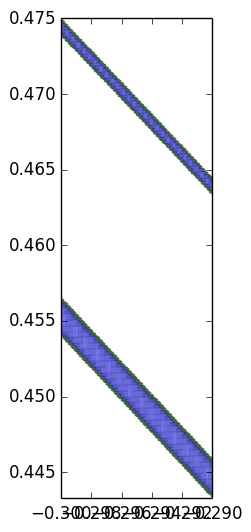

(-0.3000000000000001,-0.2900000000000001,0.4432617187499999,0.4749999999999999)

.129397 seconds (234.06 M allocations: 27.081 GB, 6.88% gc time)


In [96]:
figure()
colors = ["red", "green", "blue"]
for i = 1:length(points)
    draw_rectangle(points[i][2].lo, points[i][1].lo, 
                    diam(points[i][2]), diam(points[i][1]), colors[purities[i]+2])

end
#axis([0, pi/3, -1, 1])
axis("image")

In [25]:
?patches

search: 

No documentation found.

`patches` is of type `Module`:

**Summary:**

```julia
type Module <: Any
```

**Fields:**

```julia
name   :: Symbol
parent :: Any
```


patches PollingFileWatcher



In [55]:
f(x) = [asin(x[1] - x[2]) - float(pi)/2, sqrt(x[1] + x[2]) - 3]
a = [Interval(-3, 8), Interval(-3, 7)];

In [56]:
points = Array{Interval, 1}[]
purities = Int[]
@time points, purities = plot_band_bisection_dirty(f, a, 1e-1);

  0.456887 seconds (1.21 M allocations: 186.689 MB, 9.66% gc time)


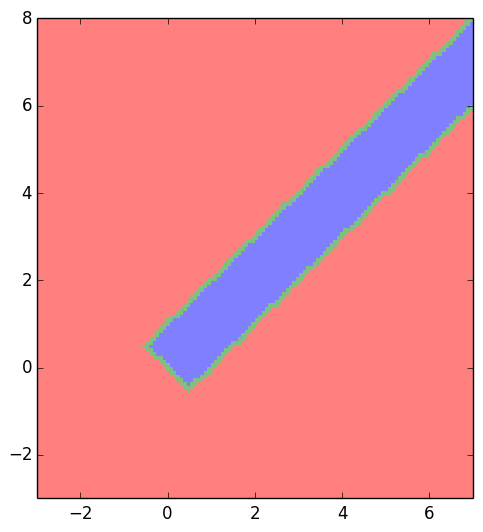

(-3.0,7.0,-3.0,8.0)

In [57]:
figure()
colors = ["red", "green", "blue"]
for i = 1:length(points)
    draw_rectangle(points[i][2].lo, points[i][1].lo, 
                    diam(points[i][2]), diam(points[i][1]), colors[purities[i]+2])

end
axis("image")